# Fitting the lower and upper polariton dispersion

Our aim is to find the position of the modes on the dispersion relation. We will retrieve the energies of the bare and coupled modes based on Gaussian fitting. To simplify the problem we will use Gaussian functions separately for finding lower and upper polariton. 

### Importing the packages

In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import utils
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.offsetbox as offsetbox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setting parameters

In [24]:
plt.rcParams.update({'font.size': 15}) # font size
cmap = plt.get_cmap('Spectral_r')  # color scale

### Importing the data

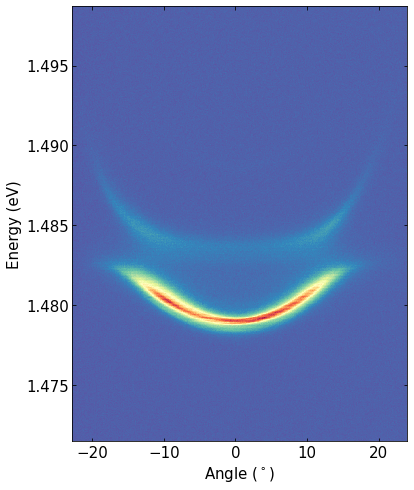

In [25]:
file = np.loadtxt('DispersionData2x2.txt')
data = file[:, 1:] # map of photoluminescence
data = utils.normalizeToUnity(data).T # normalizing the data (not obligatory)
enereV = utils.nmtoeV(file[:, 0]) # energy in eV
angles = utils.angleVec(k0=248) # angle in degrees
# print(enereV)
# print(angle)
# print(data)

# Preview of loaded data
fig, ax = plt.subplots(1,1, figsize=(6, 8), facecolor='w', edgecolor='k')   # new canva for a plot
ax.pcolormesh(angles, enereV, data.T, cmap=cmap, shading='auto') # plotting the map with coordinates given by two lists
ax.set_xlabel('Angle ($^\circ$)') # x label
ax.set_ylabel('Energy (eV)') # y label
ax.tick_params(axis='both', direction = "in", which='major',
       right = True, top = True, left = True) # ticks properties
plt.show() # showing the plot

The presented photoluminescence map shows two exciton-polariton modes resulting from strong coupling between the exciton and photon. In the first step we plan to find the positions of the lower and upper polariton. We will make cross sections of a map and fit the photoluminescence peaks for each angle. 

### Fitting procedure

We plot the cross section at zero angle to roughly estimate the initial parameters for fitting procedure.

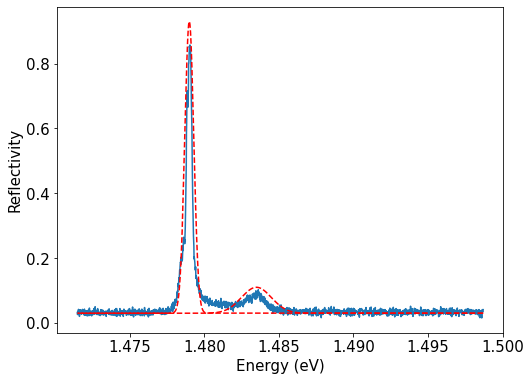

In [26]:
zeroDeg = utils.valueIndex(angles, 0)[1] # finding index of zero degree in angles

# initial parameters
popt = [0.03, 0.9, 1.479, 0.0003] # initial parameters for first peak

popt2 = [0.03, 0.08, 1.4835, 0.001] # initial parameters for second peak

# Plotting the cross section at zero angle
fig, ax = plt.subplots(1,1, figsize=(8, 6), facecolor='w', edgecolor='k')   # new canva for a plot
ax.plot(enereV, data[zeroDeg, :]) # plotting the cross section at zero angle
ax.plot(enereV, utils.FG1_c(enereV,*popt), 'r--') # plotting the cross section at zero angle
ax.plot(enereV, utils.FG1_c(enereV,*popt2), 'r--') # plotting the cross section at zero angle
ax.set_xlabel('Energy (eV)') # x label
ax.set_ylabel('Reflectivity') # y label
plt.show()

We plan to fit in two parallel loops starting from the center of the map where the cross section is very well defined and going to the edges. The parameters found in the negative angles will be initial parameters for corresponding positive angles. Before the Gaussian fitting we will find roughly positions of the maxima to improve the fitting procedure.  

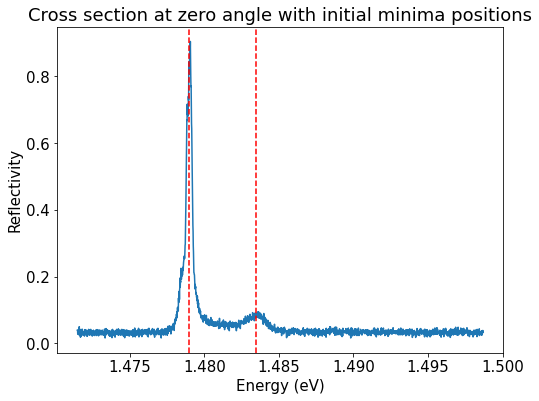

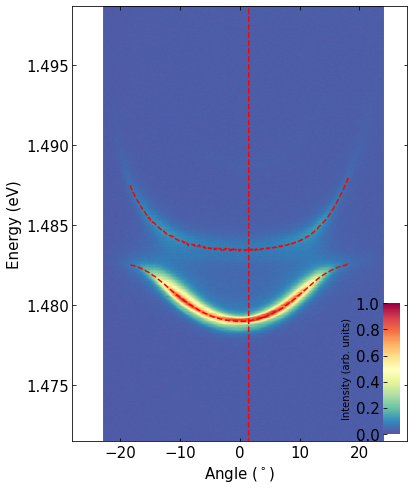

In [27]:
n_pix = 196 # defines the range of fitted angles
zakp = zeroDeg # idx1 of first range
zakk = zeroDeg + n_pix # idx2 of first range

zakp2 = zeroDeg - n_pix # idx1 of second range
zakk2 = zeroDeg # idx2 of second range

modes_pos_right = [] # position of the modes for positive angles 
modes_pos_left = [] # position of the modes for negative angles

for i, j in zip(range(zakp2, zakk2)[::-1], range(zakp, zakk)): # two loops going through the set ranges
    fit_data = data[i, :] # crossection from the second range (of negative angles) 
    if j == zeroDeg: 
        min_px, min2_px = utils.FindMaximaFirst2(fit_data, start_px=510) # finding the local maxima at zero emisssion angle
        fig, ax = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')        
        plt.plot(enereV, fit_data)
        ax.axvline(x=popt[2], color='r', linestyle='--')
        ax.axvline(x=popt2[2], color='r', linestyle='--')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Reflectivity')
        plt.title('Cross section at zero angle with initial minima positions')
        plt.show()
    else:
        min_px, min2_px, = utils.FindMaximaNext2(fit_data, min_px, min2_px, width = 30) # finding the local maxima in the cross section based on previously found minima
        popt[2], popt2[2] = enereV[min_px], enereV[min2_px]
    try:       
        # fitting the Gaussian function to each mode
        popt, pcov = utils.fit_FG1_c(enereV, fit_data, *popt,
                                    fitrange = [popt[2]-3*popt[3],popt[2]+3*popt[3]], bounds = None)
        popt2, pcov2 = utils.fit_FG1_c(enereV, fit_data, *popt2,
                                    fitrange = [popt2[2]-1*popt2[3],popt2[2]+6*popt2[3]], bounds = None)
        modes_pos_left.append([popt[2], popt2[2]])  # saving the found energies
    except RuntimeError:
        # if fitting was failed, the parameters are taken from the previous fit
        print("Error - curve_fit failed " + str(i))   
        popt[2] = modes_pos_left[-1][0]
        popt2[2] = modes_pos_left[-1][1] 
        modes_pos_left.append([popt[2], popt2[2]])
    fit_data = data[j, :] # crossection from the first range (of positive angles) 
    try:     
        # fitting the Gaussian function to each mode
        popt, pcov = utils.fit_FG1_c(enereV, fit_data, *popt,
                                    fitrange = [popt[2]-3*popt[3],popt[2]+3*popt[3]], bounds = None)
        popt2, pcov2 = utils.fit_FG1_c(enereV, fit_data, *popt2,
                                    fitrange = [popt2[2]-1*popt2[3],popt2[2]+6*popt2[3]], bounds = None)
        modes_pos_right.append([popt[2], popt2[2]])
    except RuntimeError:
        # if fitting was failed, the parameters are taken from the previous fit
        print("Error - curve_fit failed " + str(j))
        popt[2] = modes_pos_right[-1][0]
        popt2[2] = modes_pos_right[-1][1]
        modes_pos_right.append([popt[2], popt2[2]])  # saving the found energies
modes_pos = utils.joinModes(modes_pos_left, modes_pos_right, angles, zakp2, zakk) # merging the found energies in both ranges
utils.plotMapWithModes(angles, enereV, data, modes_pos) # plotting the found energies on a photoluminescence map        

### Fitting the solutions of the Schroedinger equation

To precisely describe the energies of the modes and retrieve the bare modes energies we will solve the Schroedinger equation for a coupled-oscillator Hamiltonian. We will fit the solution of this equation to the previously found energies of the modes. Both lower and upper polariton branches will be fitted simultaneously.

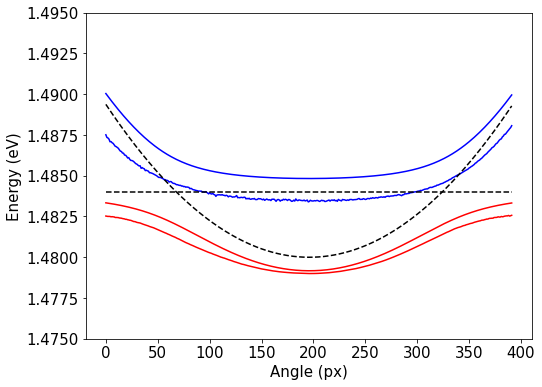

In [28]:
angles_px = np.linspace(1, len(modes_pos), len(modes_pos)) 
combo_angles_px = np.concatenate([angles_px, angles_px]) # list of angles for lower polariton and upper polariton
combo_modes_pos = np.concatenate([modes_pos[:,1], modes_pos[:,2]]) # list of energies of lower polariton and upper polariton
utils.setDataLength(modes_pos) # saves globally the number of found energies
params = np.array([1.484, 0.004, 1.480, 1.5*10**(-5)]) # initial parameters for fitting
utils.plotInitParams2x2(modes_pos, *params, ylim = [1.475, 1.495]) # plot modes for initial parameters together with the found energies of lp and up

In [29]:
fittedParams, pcov = curve_fit(utils.combinedF2x2, combo_angles_px, combo_modes_pos, params) # fitting the eigenvalues of the Hamiltonian
perr = np.sqrt(np.diag(pcov)) # calculating the standard deviation 
E1, Om1, c, d = fittedParams # unpacking the parameters
y_fit_1 = utils.solveH2x2(*fittedParams)[0] # first data set, first equation
y_fit_2 = utils.solveH2x2(*fittedParams)[1] # second data set, second equation

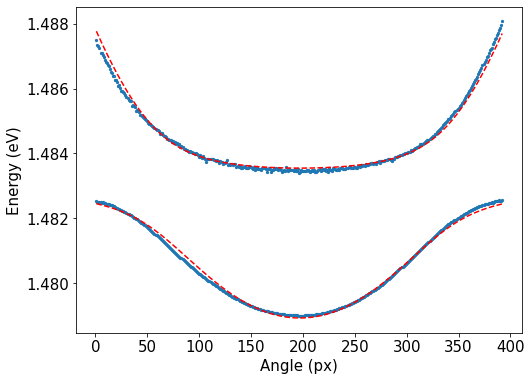

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k') 
ax.scatter(combo_angles_px, combo_modes_pos, s=5) # plot the raw data
ax.plot(angles_px, y_fit_1, 'r--') # plot the equation using the fitted parameters
ax.plot(angles_px, y_fit_2, 'r--') # plot the equation using the fitted parameters
ax.set_xlabel('Angle (px)')
ax.set_ylabel('Energy (eV)')
plt.show()

The fitting procedure allowed us to obtain the energies of lower polariton and upper polariton with satisfactory result. We plot the modes together with the photoluminescence map.

### Plotting the result

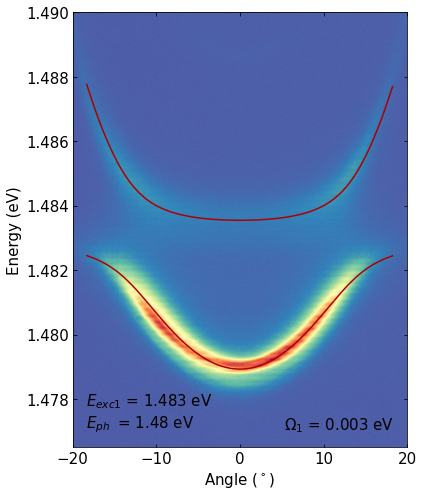

In [31]:
fig, ax = plt.subplots(1,1, figsize=(6, 8), facecolor='w', edgecolor='k')  
draw_map = ax.pcolormesh(angles, enereV, data.T, cmap=cmap,  alpha=1, shading ='gouraud', vmin=0)

k0 = 248

plt.plot(angles[zakp2:zakk], y_fit_1, color = [174/255, 0, 0])
plt.plot(angles[zakp2:zakk], y_fit_2, color = [174/255, 0, 0])

# ax.axhline(y=E1, color = [0, 0, 174/255], linestyle = '--')

# plt.plot(angles[zakp2:zakk], c+d*np.array(angles[zakp2:zakk])*np.array(angles[zakp2:zakk]), color = [0, 0, 174/255], linestyle = '--')


downanno = offsetbox.AnchoredText('$E_{exc1}$ = ' + str(round(E1,3)) +
                                  ' eV \n$E_{ph~}$ = ' + str(round(c,3)) + ' eV',
                                    loc=3, frameon=False)
ax.add_artist(downanno)
downanno2 = offsetbox.AnchoredText('$\Omega_1$ = ' + str(round(Om1,3)) + ' eV', 
                                    loc=4, frameon=False)
ax.add_artist(downanno2)
        
ax.set_xlabel('Angle ($^\circ$)')
ax.set_ylabel('Energy (eV)')
ax.set_xlim((-20, 20))
ax.set_ylim(1.4765, 1.49)
ax.tick_params(axis='both', direction = "in", which='major',
       right = True, top = True, left = True)